In [1]:
import requests
import zipfile
import os
import pandas as pd
import dask.dataframe as dd
import warnings
import shutil

# 抑制 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# 远程文件的 URL
url = 'https://fema.gov/about/reports-and-data/openfema/nfirs_fire_hazmat_pdr_2022.zip'

# 本地保存的文件名
local_zip_file = 'nfirs_fire_hazmat_pdr_2022.zip'

# 第一级解压缩后的文件夹名
first_extracted_folder = 'nfirs_fire_hazmat_pdr_2022'

# 第二级解压缩后的文件夹名
second_extracted_folder = os.path.join(first_extracted_folder, 'NFIRS_FIRES_2022_102623')

# 下载文件
response = requests.get(url)
with open(local_zip_file, 'wb') as f:
    f.write(response.content)
print(f"Downloaded {local_zip_file}")

# 解压缩第一级文件
with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
    zip_ref.extractall(first_extracted_folder)
print(f"Extracted files to {first_extracted_folder}")

# 解压缩第二级文件
second_zip_file = os.path.join(first_extracted_folder, 'nfirs_fire_hazmat_pdr_2022', 'NFIRS_FIRES_2022_102623.zip')
with zipfile.ZipFile(second_zip_file, 'r') as zip_ref:
    zip_ref.extractall(second_extracted_folder)
print(f"Extracted files to {second_extracted_folder}")

# 列出解压后的目录结构
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

list_files(second_extracted_folder)


Downloaded nfirs_fire_hazmat_pdr_2022.zip
Extracted files to nfirs_fire_hazmat_pdr_2022
Extracted files to nfirs_fire_hazmat_pdr_2022/NFIRS_FIRES_2022_102623
NFIRS_FIRES_2022_102623/
    incidentaddress.txt
    fireincident.txt
    civiliancasualty.txt
    hazchem.txt
    arson.txt
    basicincident.txt
    hazmat.txt
    wildlands.txt
    arsonjuvsub.txt
    ems.txt
    hazmatequipinvolved.txt
    codelookup.txt
    ffcasualty.txt
    fdheader.txt
    hazmobprop.txt
    basicaid.txt
    ffequipfail.txt
    basicincident_processed.csv
    arsonagencyreferal.txt
    .ipynb_checkpoints/
        basicincident_processed-checkpoint.csv


In [2]:
import pandas as pd
import os

# 文件路径
basicincident_file = os.path.join(second_extracted_folder, 'basicincident.txt')
processed_csv_file = os.path.join(second_extracted_folder, 'basicincident_processed.csv')

# 处理并转换日期时间格式的函数
def convert_datetime(dt_str):
    return pd.to_datetime(dt_str, format='%m%d%Y%H%M', errors='coerce')

# 处理basicincident.txt文件
def process_basicincident(file_path):
    chunk_size = 10000  # 每次读取的行数
    chunks = []
    total_rows = 0  # 记录总行数
    ca_rows = 0  # 记录CA行数

    for chunk in pd.read_csv(file_path, delimiter='^', encoding='latin1', low_memory=False, chunksize=chunk_size):
        total_rows += len(chunk)
        # 过滤出加利福尼亚州的数据
        chunk_ca = chunk[chunk['STATE'] == 'CA']
        ca_rows += len(chunk_ca)

        # 转换日期和时间格式
        chunk_ca['ALARM'] = chunk_ca['ALARM'].apply(convert_datetime)
        chunk_ca['ARRIVAL'] = chunk_ca['ARRIVAL'].apply(convert_datetime)
        chunk_ca['LU_CLEAR'] = chunk_ca['LU_CLEAR'].apply(convert_datetime)

        # 确保列转换为日期时间类型
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['ALARM']):
            chunk_ca['ALARM'] = pd.to_datetime(chunk_ca['ALARM'], errors='coerce')
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['ARRIVAL']):
            chunk_ca['ARRIVAL'] = pd.to_datetime(chunk_ca['ARRIVAL'], errors='coerce')
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['LU_CLEAR']):
            chunk_ca['LU_CLEAR'] = pd.to_datetime(chunk_ca['LU_CLEAR'], errors='coerce')

        # 丢弃ALARM和ARRIVAL中为空的行
        chunk_ca = chunk_ca.dropna(subset=['ALARM', 'ARRIVAL'])

        # 计算响应时间和解决火灾的时间
        chunk_ca['RESPONSE_TIME'] = (chunk_ca['ARRIVAL'] - chunk_ca['ALARM']).dt.total_seconds() / 60  # 以分钟为单位
        chunk_ca['FIRE_CLEARANCE_TIME'] = (chunk_ca['LU_CLEAR'] - chunk_ca['ARRIVAL']).dt.total_seconds() / 60  # 以分钟为单位

        chunks.append(chunk_ca)

    # 合并所有处理后的数据块
    processed_df = pd.concat(chunks, ignore_index=True)
    
    # 保存为CSV文件
    processed_df.to_csv(processed_csv_file, index=False)
    print(f"Processed data saved to {processed_csv_file}")
    print(f"Total rows: {total_rows}, CA rows: {ca_rows}")

    # 输出前几行查看结果
    print(processed_df)

# 运行处理函数
process_basicincident(basicincident_file)


/tmp/ipykernel_46421/2283616722.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_ca['ALARM'] = chunk_ca['ALARM'].apply(convert_datetime)
/tmp/ipykernel_46421/2283616722.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_ca['ARRIVAL'] = chunk_ca['ARRIVAL'].apply(convert_datetime)
/tmp/ipykernel_46421/2283616722.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Processed data saved to nfirs_fire_hazmat_pdr_2022/NFIRS_FIRES_2022_102623/basicincident_processed.csv
Total rows: 2370774, CA rows: 222190
                       INCIDENT_KEY STATE   FDID  INC_DATE   INC_NO  EXP_NO  \
0       CA_01005_01062022_2200140_0    CA   1005   1062022  2200140       0   
1       CA_01005_01092022_2200193_0    CA   1005   1092022  2200193       0   
2       CA_01005_01162022_2200401_0    CA   1005   1162022  2200401       0   
3       CA_01005_01172022_2200411_0    CA   1005   1172022  2200411       0   
4       CA_01005_01182022_2200434_0    CA   1005   1182022  2200434       0   
...                             ...   ...    ...       ...      ...     ...   
217074  CA_58555_10222022_0029046_0    CA  58555  10222022    29046       0   
217075  CA_58555_10292022_0029650_0    CA  58555  10292022    29650       0   
217076  CA_58555_10302022_0029767_0    CA  58555  10302022    29767       0   
217077  CA_58555_11062022_0030386_0    CA  58555  11062022    30386   

In [3]:
import pandas as pd
import geopandas as gpd

# 文件路径
processed_csv_file = 'nfirs_fire_hazmat_pdr_2022/NFIRS_FIRES_2022_102623/basicincident_processed.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
output_file = 'filtered_fire_data.csv'

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 FDID 列为字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 空列表存储分块处理后的数据
chunks = []
chunk_size = 10000  # 每次处理的行数

# 分块读取火灾数据并过滤加利福尼亚州的数据
dtypes = {
    'FDID': str,
    'STATE': str,
    'RESPONSE_TIME': float,
    'FIRE_CLEARANCE_TIME': float,
    'ALARM': str,
    'ARRIVAL': str,
    'LU_CLEAR': str
}

for chunk in pd.read_csv(processed_csv_file, chunksize=chunk_size, dtype=dtypes, low_memory=False):
    chunk_ca = chunk[chunk['STATE'] == 'CA']
    chunks.append(chunk_ca[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']])

# 合并所有分块
fire_data_ca = pd.concat(chunks)

# 保存处理后的数据
fire_data_ca.to_csv(output_file, index=False)
print(f"Filtered data saved to {output_file}")


Filtered data saved to filtered_fire_data.csv


In [4]:
import dask.dataframe as dd
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
from scipy.sparse import csr_matrix
import numpy as np

# 文件路径
filtered_data_file = 'filtered_fire_data.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取过滤后的火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保火灾数据中的 FDID 列为字符串类型
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 将 fire_data_ca 转换为 pandas DataFrame
fire_data_ca = fire_data_ca.compute()

# 合并数据并仅保留必要的列
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']], on='FDID', how='inner')

# 检查合并后的数据大小
print(f"Size of merged data: {merged.shape}")

# 检查合并后的数据
print(merged.head())


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

Size of merged data: (185016, 4)
    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   

   FIRE_CLEARANCE_TIME  
0                  5.0  
1                 54.0  
2                  6.0  
3                 67.0  
4                 44.0  


In [ ]:
import pandas as pd
import geopandas as gpd
import os

# 文件路径
filtered_data_file = 'filtered_fire_data.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
merged_data_file = 'merged_fire_data.csv'

# 读取过滤后的火灾数据
fire_data_ca = pd.read_csv(filtered_data_file)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保火灾数据中的 FDID 列为字符串类型
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并数据并仅保留必要的列
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']], on='FDID', how='inner')

# 将合并后的数据保存为CSV文件
merged.to_csv(merged_data_file, index=False)

print(f"Merged data saved to {merged_data_file}")


In [ ]:
#=================response time==================

In [7]:
import dask.dataframe as dd

# 使用Dask读取合并后的数据
merged_data_file = 'merged_fire_data.csv'
merged = dd.read_csv(merged_data_file)

# 确保Dask dataframe中FDID是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  
0                  5.0  
1                 54.0  
2                  6.0  
3                 67.0  
4                 44.0  


In [8]:
# 为 FDID 生成一个索引
fdid_unique = merged['FDID'].unique().compute()
fdid_index = {fdid: idx for idx, fdid in enumerate(fdid_unique)}
merged['FDID_index'] = merged['FDID'].map(fdid_index)

# 显示前几行，确保索引正确生成
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  FDID_index  
0                  5.0           0  
1                 54.0           0  
2                  6.0           0  
3                 67.0           0  
4                 44.0           0  


In [9]:
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 定义计算 Moran's I 的函数
def compute_moran(chunk):
    fdid_index_values = chunk['FDID_index'].values
    y_response = chunk['RESPONSE_TIME'].values
    
    # 创建权重矩阵
    coords = np.array(list(enumerate(fdid_index_values)))
    w = DistanceBand(coords, threshold=1.5, binary=True, silence_warnings=True)
    
    moran_response = Moran(y_response, w)
    return moran_response.I, moran_response.p_norm


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [10]:
# 分块计算 Moran's I
results = merged.map_partitions(compute_moran, meta=('I', 'f8')).compute()

# 显示计算结果
print(results)


0      (0.1869080885801824, 2.3345538833475772e-07)
1       (-0.002292581983506457, 0.9895168858850243)
2        (0.05995442161717584, 0.24954243202863635)
3        (0.028091038634287222, 0.5695629396969921)
4        (0.07913234747640562, 0.13304116196866597)
                           ...                     
251      (-0.03747534516765286, 0.8068809115256549)
252     (-0.17478866235703633, 0.12689530984193206)
253       (0.04988202939496858, 0.5649803274052243)
254     (0.0036917593142663115, 0.8860342642035959)
255     (-0.014733705420490024, 0.9768195435710966)
Length: 256, dtype: object


In [11]:
import pandas as pd
# 将结果转换为 DataFrame
results_df = pd.DataFrame(results.tolist(), columns=['Moran_I', 'p_value'])

# 添加 FDID 列
results_df['FDID'] = merged['FDID'].unique().compute()

# 保存结果到 CSV 文件
results_df.to_csv('morans_i_results2022_rt.csv', index=False)

In [12]:
# 计算总体的 Moran's I 平均值
average_moran_i = np.mean([res[0] for res in results])
average_p_value = np.mean([res[1] for res in results])

# 输出结果
print(f"Average Response Time Moran's I: {average_moran_i}")
print(f"Average Response Time P-value: {average_p_value}")

if average_p_value < 0.05:
    print("存在显著的火灾响应时间空间自相关")
else:
    print("没有显著的火灾响应时间空间自相关")


Average Response Time Moran's I: 0.018162358167005697
Average Response Time P-value: 0.5028407802078705
没有显著的火灾响应时间空间自相关


    Moran_I       p_value   FDID
0  0.186908  2.334554e-07  10005
1 -0.002293  9.895169e-01  10010
2  0.059954  2.495424e-01  10030
3  0.028091  5.695629e-01  10040
4  0.079132  1.330412e-01  10045
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  9

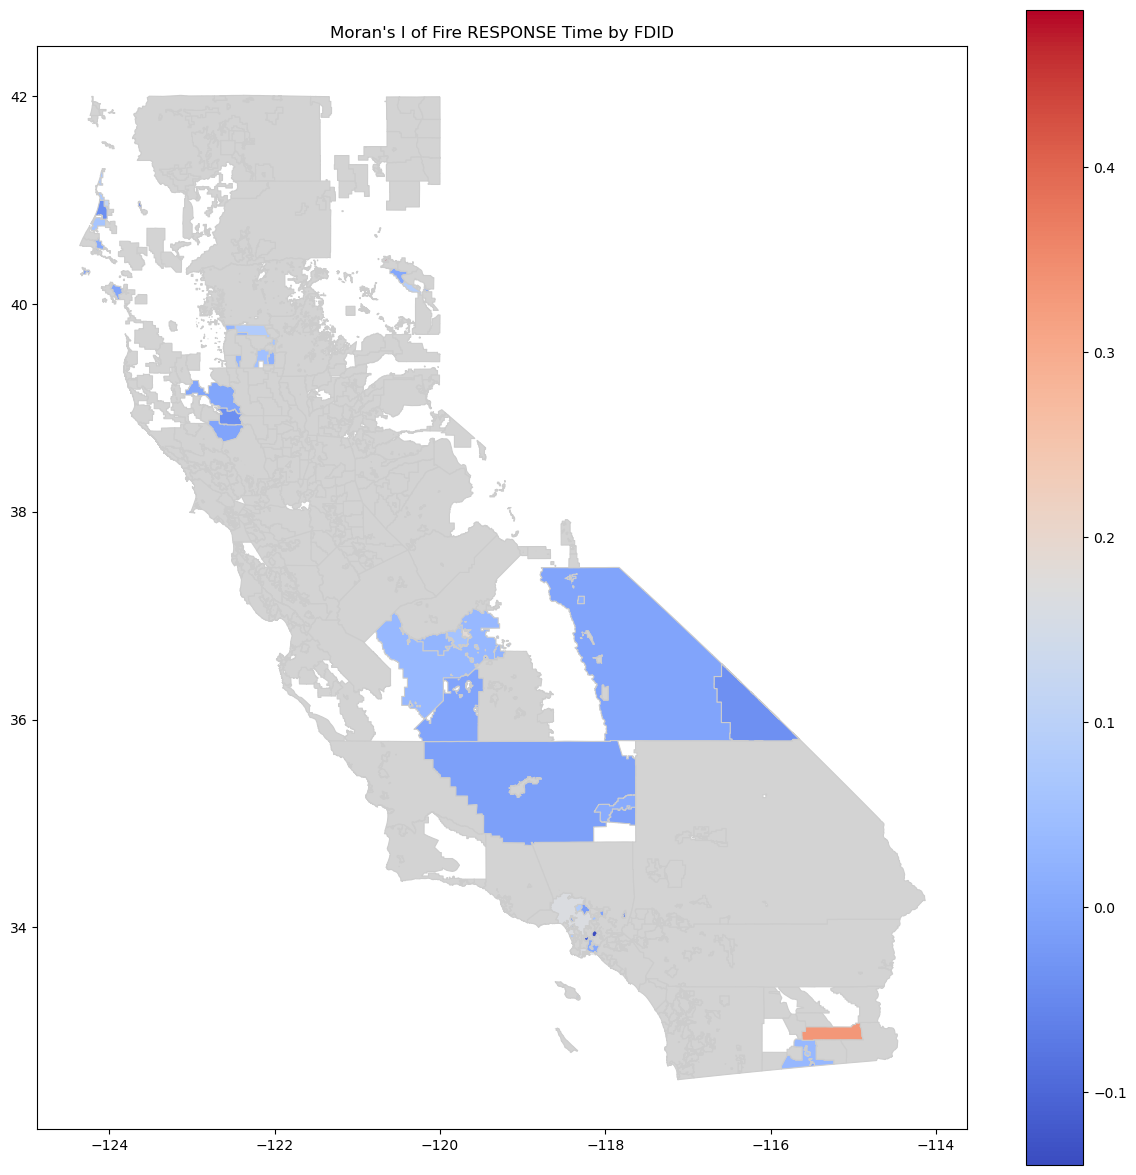

In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_i_results2022_rt.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire RESPONSE Time by FDID')
plt.show()


In [ ]:
#============='FIRE_CLEARANCE_TIME'===============

In [1]:
import dask.dataframe as dd

# 使用Dask读取合并后的数据
merged_data_file = 'merged_fire_data.csv'
merged = dd.read_csv(merged_data_file)

# 确保Dask dataframe中FDID是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  
0                  5.0  
1                 54.0  
2                  6.0  
3                 67.0  
4                 44.0  


In [2]:
# 为 FDID 生成一个索引
fdid_unique = merged['FDID'].unique().compute()
fdid_index = {fdid: idx for idx, fdid in enumerate(fdid_unique)}
merged['FDID_index'] = merged['FDID'].map(fdid_index)

# 显示前几行，确保索引正确生成
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  FDID_index  
0                  5.0           0  
1                 54.0           0  
2                  6.0           0  
3                 67.0           0  
4                 44.0           0  


In [3]:
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 定义计算 Moran's I 的函数
def compute_moran(chunk):
    fdid_index_values = chunk['FDID_index'].values
    y_response = chunk['FIRE_CLEARANCE_TIME'].values
    
    # 创建权重矩阵
    coords = np.array(list(enumerate(fdid_index_values)))
    w = DistanceBand(coords, threshold=1.5, binary=True, silence_warnings=True)
    
    moran_response = Moran(y_response, w)
    return moran_response.I, moran_response.p_norm


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [4]:
# 分块计算 Moran's I
results = merged.map_partitions(compute_moran, meta=('I', 'f8')).compute()

# 显示计算结果
print(results)


0       (0.1280758101958326, 0.0003787091202058041)
1      (0.29122569811755106, 7.725738788897413e-08)
2         (0.00578075107903198, 0.8723685184874449)
3        (0.0034097403755794257, 0.906633387353012)
4       (0.09916829319603328, 0.061669488438030544)
                           ...                     
251       (-0.0169045782976063, 0.9594013317159595)
252     (-0.005669566060136167, 0.9555460557867217)
253    (0.3741738966287648, 0.00030691588066424823)
254       (0.02088362825375768, 0.7610032552406727)
255       (-0.02097399858518296, 0.930323432705862)
Length: 256, dtype: object


In [6]:
import pandas as pd
# 将结果转换为 DataFrame
results_df = pd.DataFrame(results.tolist(), columns=['Moran_I', 'p_value'])

# 添加 FDID 列
results_df['FDID'] = merged['FDID'].unique().compute()

# 保存结果到 CSV 文件
results_df.to_csv('morans_i_results2022.csv', index=False)

In [7]:
# 过滤掉包含 nan 的结果
filtered_results = [res for res in results if not np.isnan(res[0]) and not np.isnan(res[1])]

# 检查是否有有效的结果
if filtered_results:
    # 计算总体的 Moran's I 平均值
    average_moran_i = np.mean([res[0] for res in filtered_results])
    average_p_value = np.mean([res[1] for res in filtered_results])

    # 输出结果
    print(f"Average Fire Clearance Time Moran's I: {average_moran_i}")
    print(f"Average Fire Clearance Time P-value: {average_p_value}")

    if average_p_value < 0.05:
        print("存在显著的火灾清除时间空间自相关")
    else:
        print("没有显著的火灾清除时间空间自相关")
else:
    print("所有分区的计算结果都包含 nan 值，无法计算总体的 Moran's I 平均值。")


Average Fire Clearance Time Moran's I: 0.07079289508281528
Average Fire Clearance Time P-value: 0.4996808136483861
没有显著的火灾清除时间空间自相关


In [8]:
import geopandas as gpd

# 读取Shapefile文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保GeoDataFrame中FDID是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(gdf.head())


    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOITO  (510) 528-5770   

  Notes  LastUpdate                                            Website  \
0   NaN  2018-06-21                                             <Null>   
1   

In [ ]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 使用 Dask 读取合并后的数据，这里包含response time
merged_data_file = 'merged_fire_data.csv'
merged = dd.read_csv(merged_data_file)

# 确保 Dask DataFrame 中 FDID 是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 将 Dask DataFrame 转换为 Pandas DataFrame 以便进一步处理
merged_pd = merged.compute()

# 计算 FDID 的索引
merged_pd['FDID_index'] = merged_pd['FDID'].factorize()[0]



/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

    Moran_I       p_value   FDID
0  0.128076  3.787091e-04  10005
1  0.291226  7.725739e-08  10010
2  0.005781  8.723685e-01  10030
3  0.003410  9.066334e-01  10040
4  0.099168  6.166949e-02  10045
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  9

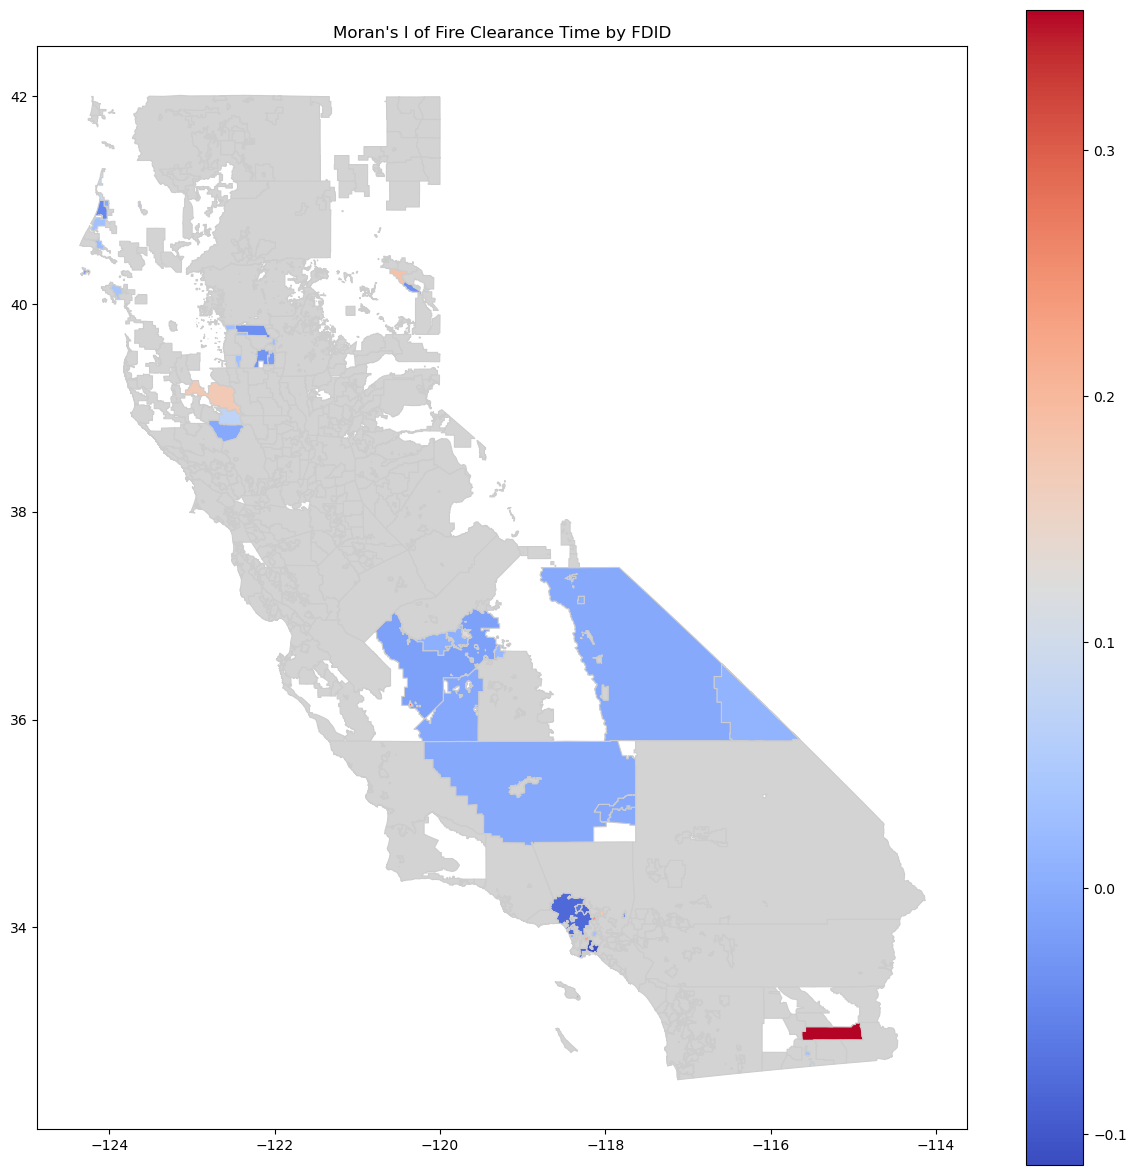

In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_i_results2022.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire Clearance Time by FDID')
plt.show()


In [ ]:
#=================K-means==================

In [15]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 文件路径
filtered_data_file = 'filtered_fire_data.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 使用Dask读取火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)

# 读取shapefile数据
gdf = gpd.read_file(shapefile_path)
gdf['FDID'] = gdf['FDID'].astype(str)

# 将Dask DataFrame转换为Pandas DataFrame
fire_data_ca = fire_data_ca.compute()

# 合并数据
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca, on='FDID', how='inner')

# 检查合并后的数据
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  
0                 30.0  
1                  4.0  
2                 17.0  
3                 14.0  
4                  7.0  


In [16]:
# 选择要聚类的列
features = ['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged[features])

# 检查标准化后的数据
print(data_scaled[:5])


[[-0.00963835 -0.01260298]
 [-0.00736058 -0.01835311]
 [-0.00849947 -0.01547804]
 [-0.00963835 -0.01614152]
 [-0.00849947 -0.01768963]]


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  
0                 30.0  
1                  4.0  
2                 17.0  
3                 14.0  
4                  7.0  
[[-0.00962474 -0.01260298]
 [-0.0073479  -0.01835311]
 [-0.00848632 -0.01547804]
 [-0.00962474 -0.01614152]
 [-0.00848632 -0.01768963]]


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

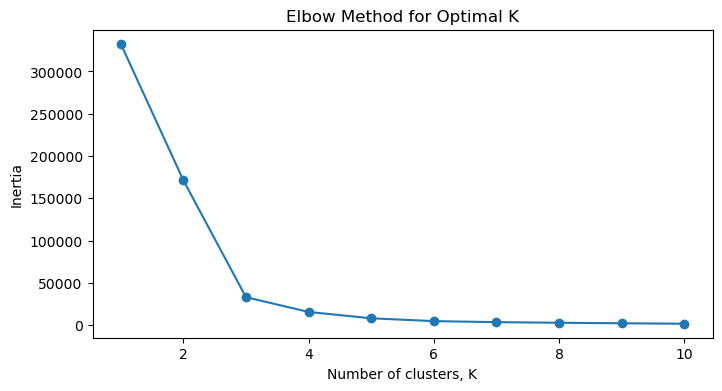

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  Cluster  
0                 30.0        0  
1                  4.0        0  
2                 17.0        0  
3                 14.0        0  
4                  7.0        0  


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


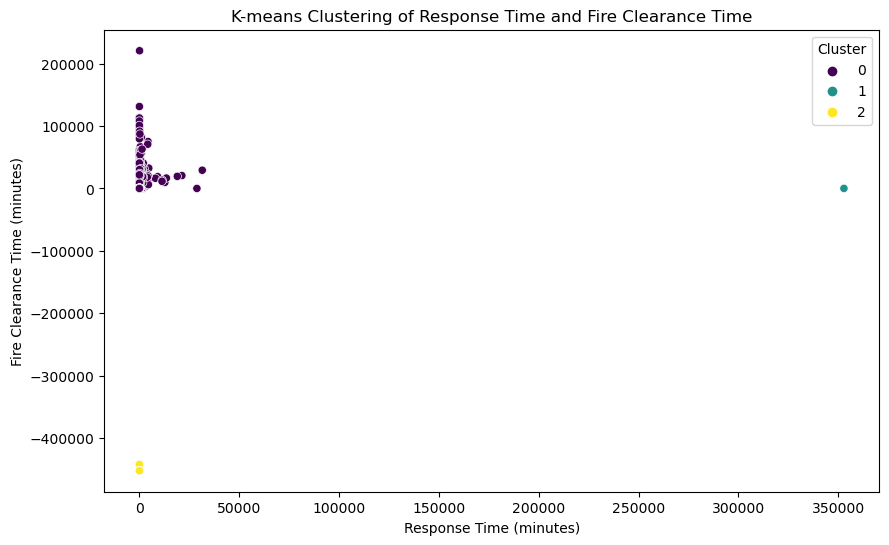

In [17]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 文件路径
filtered_data_file = 'filtered_fire_data.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 使用Dask读取火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)

# 读取shapefile数据
gdf = gpd.read_file(shapefile_path)
gdf['FDID'] = gdf['FDID'].astype(str)

# 将Dask DataFrame转换为Pandas DataFrame
fire_data_ca = fire_data_ca.compute()

# 合并数据
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca, on='FDID', how='inner')

# 检查合并后的数据
print(merged.head())

# 删除包含缺失值的样本
merged = merged.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 选择要聚类的列
features = ['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged[features])

# 检查标准化后的数据
print(data_scaled[:5])

# 使用Elbow方法选择K值
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# 可视化Elbow方法
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# 应用K-means聚类 (假设选择的K值为3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# 将聚类结果添加到原始数据中
merged['Cluster'] = clusters

# 检查聚类结果
print(merged.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged['RESPONSE_TIME'], y=merged['FIRE_CLEARANCE_TIME'], hue=merged['Cluster'], palette='viridis')
plt.title('K-means Clustering of Response Time and Fire Clearance Time')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


NameError: name 'merged' is not defined

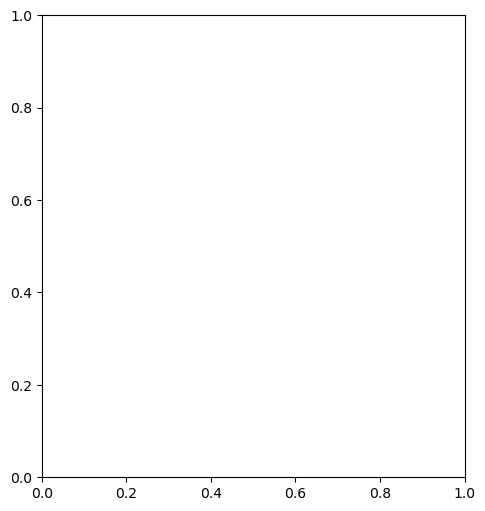

In [4]:
import matplotlib.pyplot as plt

# 绘制箱线图识别异常值
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(merged['RESPONSE_TIME'])
plt.title('Boxplot of Response Time')
plt.ylabel('Response Time (minutes)')

plt.subplot(1, 2, 2)
plt.boxplot(merged['FIRE_CLEARANCE_TIME'])
plt.title('Boxplot of Fire Clearance Time')
plt.ylabel('Fire Clearance Time (minutes)')

plt.show()


In [19]:
# 定义删除异常值的函数
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 删除响应时间和火灾清除时间中的异常值
merged_cleaned = remove_outliers(merged, 'RESPONSE_TIME')
merged_cleaned = remove_outliers(merged_cleaned, 'FIRE_CLEARANCE_TIME')

# 检查删除异常值后的数据
print(merged_cleaned.describe())


       RESPONSE_TIME  FIRE_CLEARANCE_TIME   Cluster
count  139652.000000        139652.000000  139652.0
mean        6.181687            20.306404       0.0
std         2.826717            18.832939       0.0
min         0.000000             0.000000       0.0
25%         4.000000             6.000000       0.0
50%         6.000000            14.000000       0.0
75%         8.000000            28.000000       0.0
max        14.000000            84.000000       0.0


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

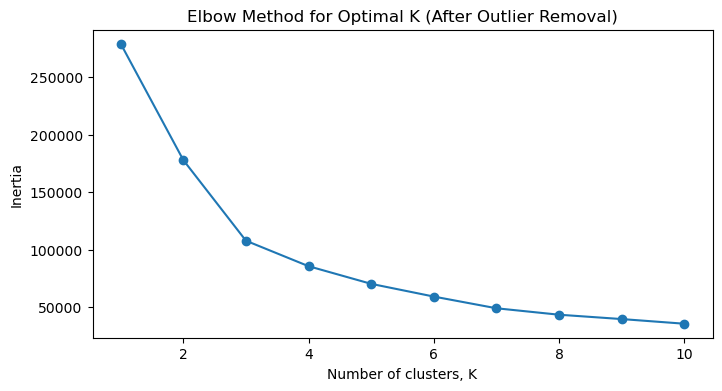

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  Cluster  
0                 30.0        2  
1                  4.0        2  
2                 17.0        2  
3                 14.0        2  
4                  7.0        2  


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


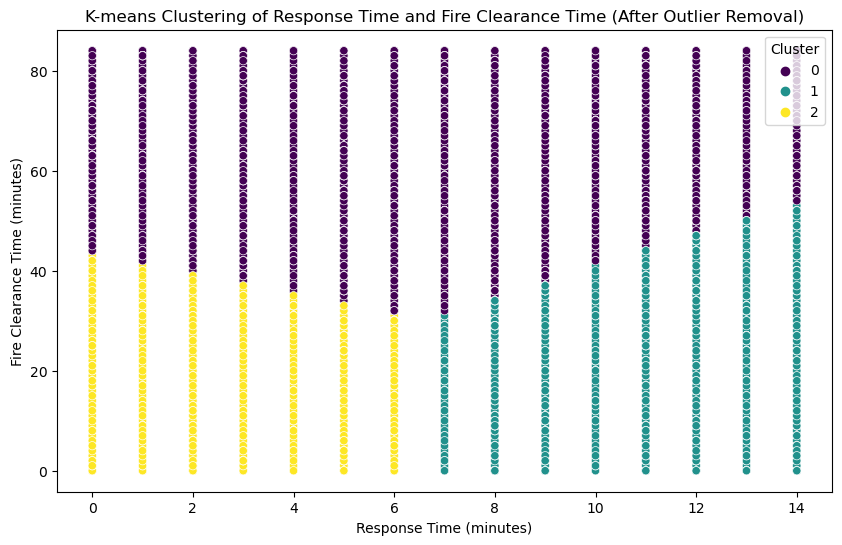

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 标准化数据
scaler = StandardScaler()
data_scaled_cleaned = scaler.fit_transform(merged_cleaned[features])

# 使用Elbow方法选择K值
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_cleaned)
    inertia.append(kmeans.inertia_)

# 可视化Elbow方法
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (After Outlier Removal)')
plt.show()

# 应用K-means聚类 (假设选择的K值为3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled_cleaned)

# 将聚类结果添加到原始数据中
merged_cleaned['Cluster'] = clusters

# 检查聚类结果
print(merged_cleaned.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_cleaned['RESPONSE_TIME'], y=merged_cleaned['FIRE_CLEARANCE_TIME'], hue=merged_cleaned['Cluster'], palette='viridis')
plt.title('K-means Clustering of Response Time and Fire Clearance Time (After Outlier Removal)')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 文件路径
filtered_data_file = 'filtered_fire_data.csv'

# 读取数据
fire_data_pd = pd.read_csv(filtered_data_file)

# 删除包含缺失值的样本
fire_data_pd = fire_data_pd.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 特征工程
X = fire_data_pd[['RESPONSE_TIME']]
y = fire_data_pd['FIRE_CLEARANCE_TIME']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
import numpy as np

# 计算响应时间和火灾清除时间的标准差
response_time_std = fire_data_pd['RESPONSE_TIME'].std()
clearance_time_std = fire_data_pd['FIRE_CLEARANCE_TIME'].std()

# 去除超过3倍标准差的异常值
filtered_data = fire_data_pd[
    (np.abs(fire_data_pd['RESPONSE_TIME'] - fire_data_pd['RESPONSE_TIME'].mean()) <= 3 * response_time_std) &
    (np.abs(fire_data_pd['FIRE_CLEARANCE_TIME'] - fire_data_pd['FIRE_CLEARANCE_TIME'].mean()) <= 3 * clearance_time_std)
]

# 更新特征和目标变量
X = filtered_data[['RESPONSE_TIME']]
y = filtered_data['FIRE_CLEARANCE_TIME']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


线性回归均方误差（MSE）：108416.0773917341
线性回归R²：0.1764314013728916


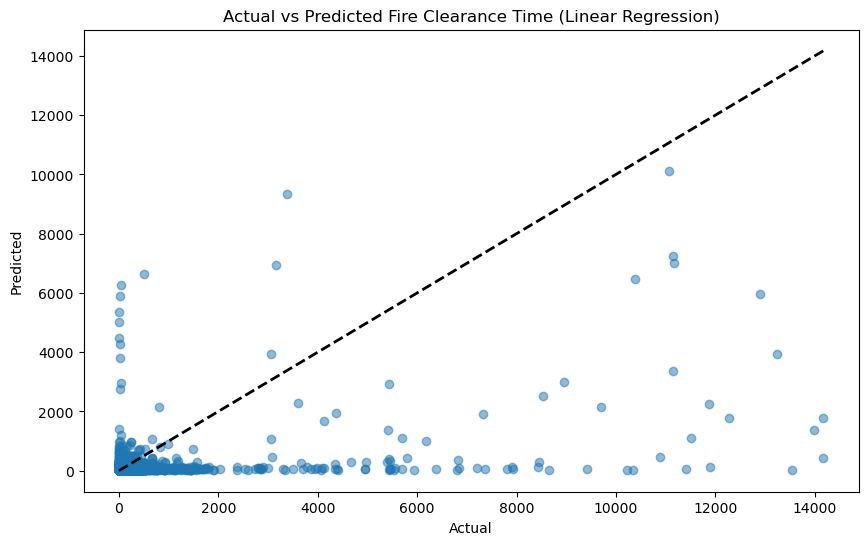

In [10]:
# 初始化和训练线性回归模型
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 进行预测
y_pred = model.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"线性回归均方误差（MSE）：{mse}")
print(f"线性回归R²：{r2}")

# 可视化预测结果与实际结果的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fire Clearance Time (Linear Regression)')
plt.show()


决策树均方误差（MSE）：117682.45944015968
决策树R²：0.10604053812121028


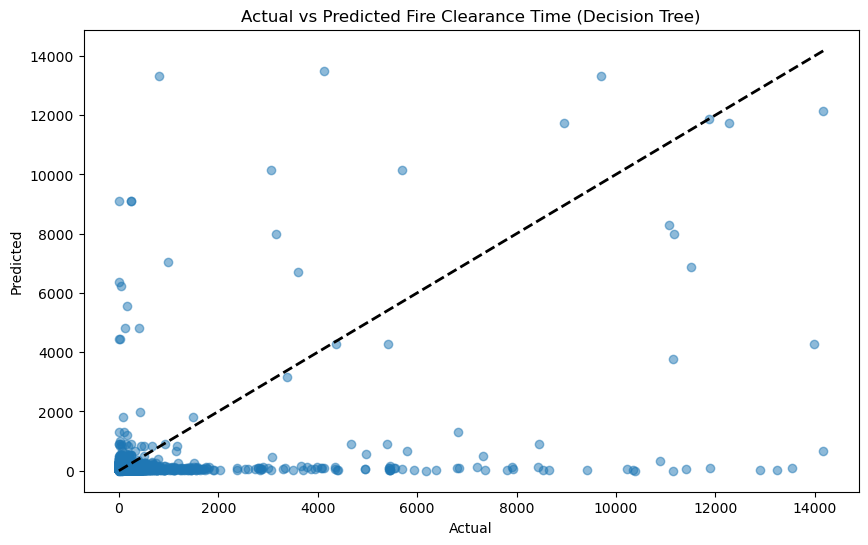

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# 初始化和训练决策树回归模型
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train)

# 进行预测
y_tree_pred = tree_model.predict(X_test_scaled)

# 评估模型
tree_mse = mean_squared_error(y_test, y_tree_pred)
tree_r2 = r2_score(y_test, y_tree_pred)

print(f"决策树均方误差（MSE）：{tree_mse}")
print(f"决策树R²：{tree_r2}")

# 可视化预测结果与实际结果的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_tree_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fire Clearance Time (Decision Tree)')
plt.show()


随机森林均方误差（MSE）：105631.22473918866
随机森林R²：0.1975861715104681


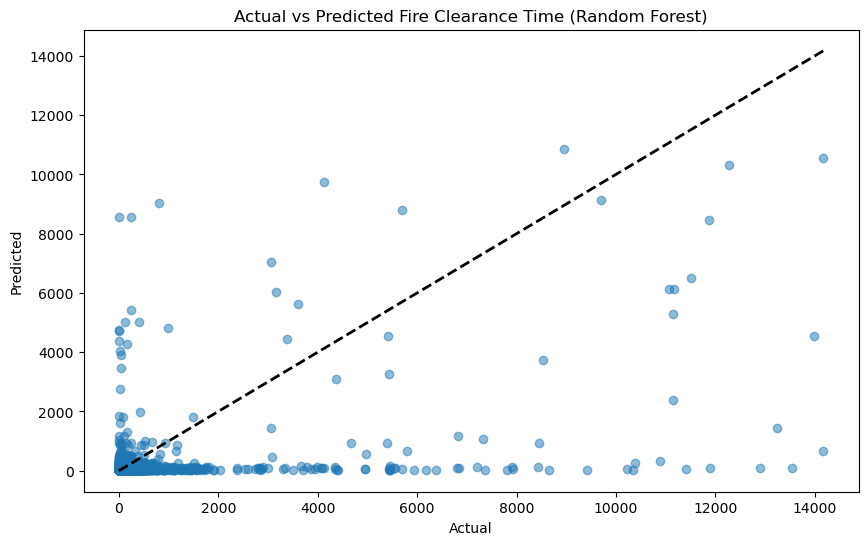

In [14]:
# 初始化和训练随机森林回归模型
forest_model = RandomForestRegressor(random_state=42, n_estimators=100)
forest_model.fit(X_train_scaled, y_train)

# 进行预测
y_forest_pred = forest_model.predict(X_test_scaled)

# 评估模型
forest_mse = mean_squared_error(y_test, y_forest_pred)
forest_r2 = r2_score(y_test, y_forest_pred)

print(f"随机森林均方误差（MSE）：{forest_mse}")
print(f"随机森林R²：{forest_r2}")

# 可视化预测结果与实际结果的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_forest_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fire Clearance Time (Random Forest)')
plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 文件路径
filtered_data_file = 'filtered_fire_data.csv'

# 读取数据
fire_data_pd = pd.read_csv(filtered_data_file)

# 删除包含缺失值的样本
fire_data_pd = fire_data_pd.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 计算响应时间和火灾清除时间的标准差
response_time_std = fire_data_pd['RESPONSE_TIME'].std()
clearance_time_std = fire_data_pd['FIRE_CLEARANCE_TIME'].std()

# 识别超过3倍标准差的异常值
outliers = fire_data_pd[
    (np.abs(fire_data_pd['RESPONSE_TIME'] - fire_data_pd['RESPONSE_TIME'].mean()) > 3 * response_time_std) |
    (np.abs(fire_data_pd['FIRE_CLEARANCE_TIME'] - fire_data_pd['FIRE_CLEARANCE_TIME'].mean()) > 3 * clearance_time_std)
]

# 去除异常值
filtered_data = fire_data_pd.drop(outliers.index)

# 更新特征和目标变量
X = filtered_data[['RESPONSE_TIME']]
y = filtered_data['FIRE_CLEARANCE_TIME']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 文件路径
initial_data_file = 'nfirs_fire_hazmat_pdr_2022/NFIRS_FIRES_2022_102623/basicincident_processed.csv'
output_file = 'morans_data/2022/filtered_fire_2022.csv'

# 读取数据
fire_data_pd = pd.read_csv(initial_data_file)

# 打印列名以确认字段名称
print("列名：", fire_data_pd.columns)

# 清理字段名称中的空格
fire_data_pd.columns = fire_data_pd.columns.str.strip()

# 确保列名正确
assert 'DEPT_STA' in fire_data_pd.columns, "DEPT_STA 列名不存在，请检查数据文件中的列名"
assert 'INC_TYPE' in fire_data_pd.columns, "INC_TYPE 列名不存在，请检查数据文件中的列名"

# 筛选DEPT_STA和INC_TYPE在100-199之间的值
filtered_data = fire_data_pd[
    (fire_data_pd['DEPT_STA'].astype(str).between('100', '199')) & 
    (fire_data_pd['INC_TYPE'].astype(str).between('100', '199'))
]

# 保留需要的列
filtered_data = filtered_data[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'DEPT_STA', 'INC_TYPE', 'SHIFT', 'PROP_VAL']]
print(f"剩余的数据量：{len(filtered_data)}")

# 计算响应时间和火灾清除时间的标准差
response_time_std = filtered_data['RESPONSE_TIME'].std()
clearance_time_std = filtered_data['FIRE_CLEARANCE_TIME'].std()

# 识别超过3倍标准差的异常值
outliers = filtered_data[
    (np.abs(filtered_data['RESPONSE_TIME'] - filtered_data['RESPONSE_TIME'].mean()) > 3 * response_time_std) |
    (np.abs(filtered_data['FIRE_CLEARANCE_TIME'] - filtered_data['FIRE_CLEARANCE_TIME'].mean()) > 3 * clearance_time_std)
]

# 去除异常值
filtered_data = filtered_data.drop(outliers.index)

# 保存处理后的数据
filtered_data.to_csv(output_file, index=False)
print(f"处理后的数据已保存到 {output_file}")


/tmp/ipykernel_7716/1118709549.py:10: DtypeWarning: Columns (7,16,17,41) have mixed types. Specify dtype option on import or set low_memory=False.
  fire_data_pd = pd.read_csv(initial_data_file)


列名： Index(['INCIDENT_KEY', 'STATE', 'FDID', 'INC_DATE', 'INC_NO', 'EXP_NO',
       'VERSION', 'DEPT_STA', 'INC_TYPE', 'ADD_WILD', 'AID', 'ALARM',
       'ARRIVAL', 'INC_CONT', 'LU_CLEAR', 'SHIFT', 'ALARMS', 'DISTRICT',
       'ACT_TAK1', 'ACT_TAK2', 'ACT_TAK3', 'APP_MOD', 'SUP_APP', 'EMS_APP',
       'OTH_APP', 'SUP_PER', 'EMS_PER', 'OTH_PER', 'RESOU_AID', 'PROP_LOSS',
       'CONT_LOSS', 'PROP_VAL', 'CONT_VAL', 'FF_DEATH', 'OTH_DEATH', 'FF_INJ',
       'OTH_INJ', 'DET_ALERT', 'HAZ_REL', 'MIXED_USE', 'PROP_USE', 'CENSUS',
       'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'],
      dtype='object')
剩余的数据量：14951
处理后的数据已保存到 morans_data/2022/filtered_fire_2022.csv


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 文件路径
filtered_data_file = 'morans_data/2022/filtered_fire_2022.csv'
output_file = 'morans_data/2022/cleaned_fire_2022.csv'

# 读取数据
fire_data_pd = pd.read_csv(filtered_data_file)

# 打印列名以确认字段名称
print("列名：", fire_data_pd.columns)

# 清理字段名称中的空格
fire_data_pd.columns = fire_data_pd.columns.str.strip()

# 确保列名正确
assert 'SHIFT' in fire_data_pd.columns, "SHIFT 列名不存在，请检查数据文件中的列名"
assert 'PROP_VAL' in fire_data_pd.columns, "PROP_VAL 列名不存在，请检查数据文件中的列名"

# 删除SHIFT列中缺失值的行，以及PROP_VAL列中为0和缺失值的行
filtered_data = fire_data_pd.dropna(subset=['SHIFT'])
filtered_data = filtered_data[filtered_data['PROP_VAL'] > 0].dropna(subset=['PROP_VAL'])

# 查看剩余数据量
print(f"剩余的数据量：{len(filtered_data)}")

# 计算响应时间和火灾清除时间的标准差
response_time_std = filtered_data['RESPONSE_TIME'].std()
clearance_time_std = filtered_data['FIRE_CLEARANCE_TIME'].std()

# 识别超过3倍标准差的异常值
outliers = filtered_data[
    (np.abs(filtered_data['RESPONSE_TIME'] - filtered_data['RESPONSE_TIME'].mean()) > 3 * response_time_std) |
    (np.abs(filtered_data['FIRE_CLEARANCE_TIME'] - filtered_data['FIRE_CLEARANCE_TIME'].mean()) > 3 * clearance_time_std)
]

# 去除异常值
filtered_data = filtered_data.drop(outliers.index)

# 保存处理后的数据
filtered_data.to_csv(output_file, index=False)
print(f"处理后的数据已保存到 {output_file}")


列名： Index(['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'DEPT_STA', 'INC_TYPE',
       'SHIFT', 'PROP_VAL'],
      dtype='object')
剩余的数据量：1818
处理后的数据已保存到 morans_data/2022/cleaned_fire_2022.csv


数据中的缺失值：
FDID                   0
RESPONSE_TIME          0
FIRE_CLEARANCE_TIME    1
DEPT_STA               0
INC_TYPE               0
SHIFT                  0
PROP_VAL               0
dtype: int64


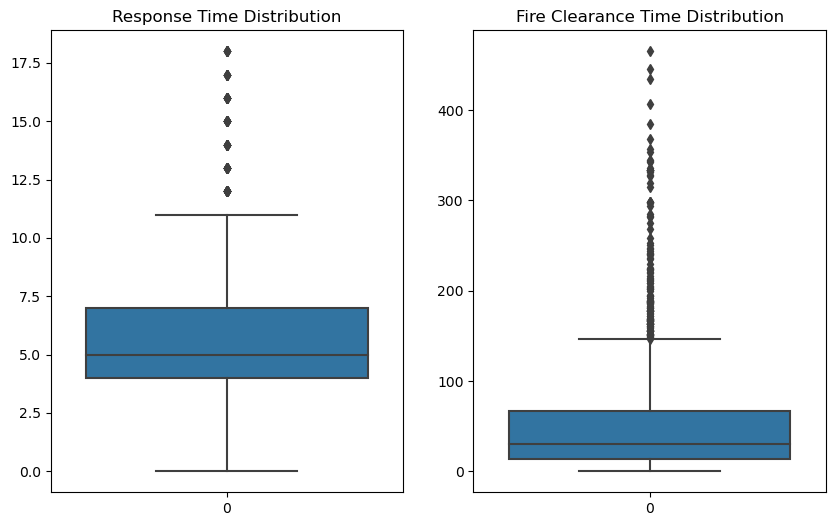

Linear Regression 均方误差（MSE）：3.0789398645917707e+27
Linear Regression R²：-9.250830902899298e+23


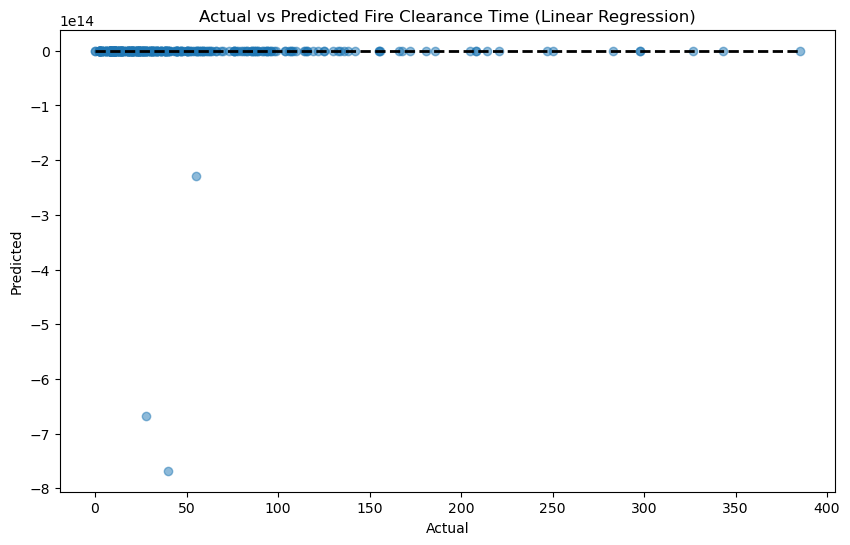

Ridge Regression 均方误差（MSE）：2464.7795225383234
Ridge Regression R²：0.25944449782379675


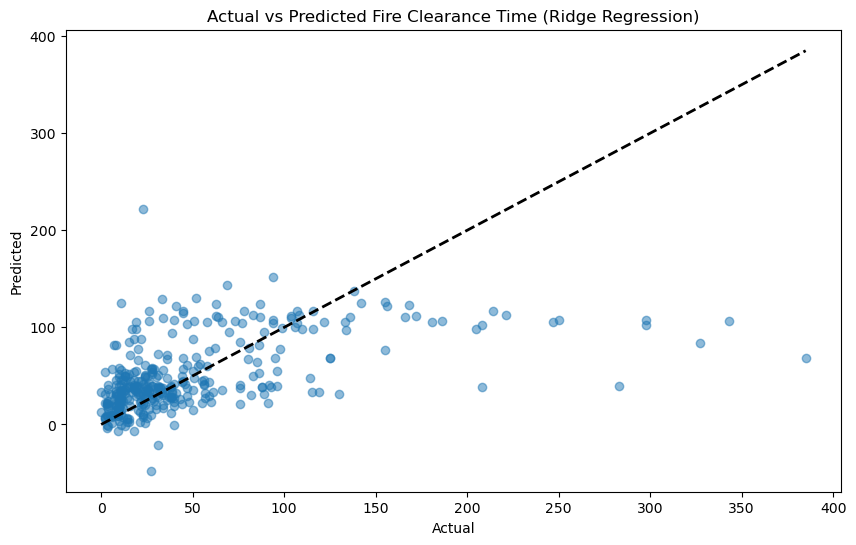

Lasso Regression 均方误差（MSE）：2445.582701772047
Lasso Regression R²：0.26521227993686625


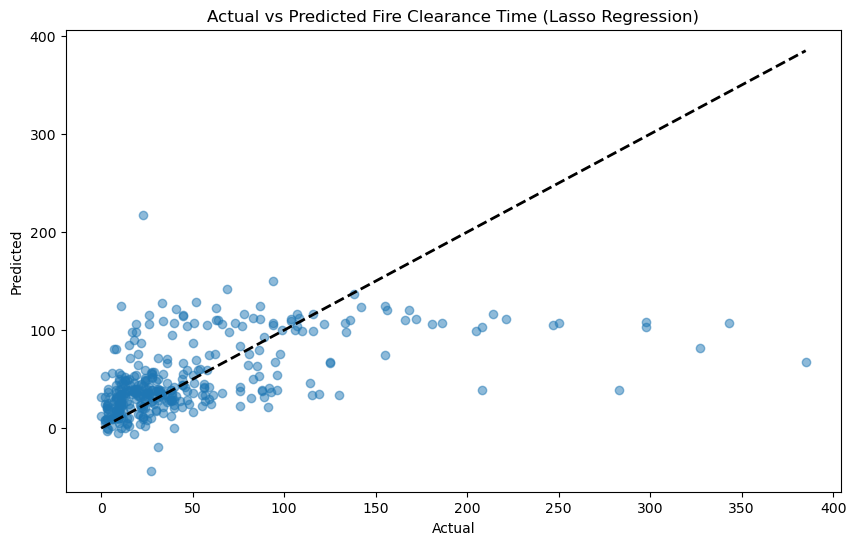

Random Forest 均方误差（MSE）：2738.3126599233083
Random Forest R²：0.1772600800835198


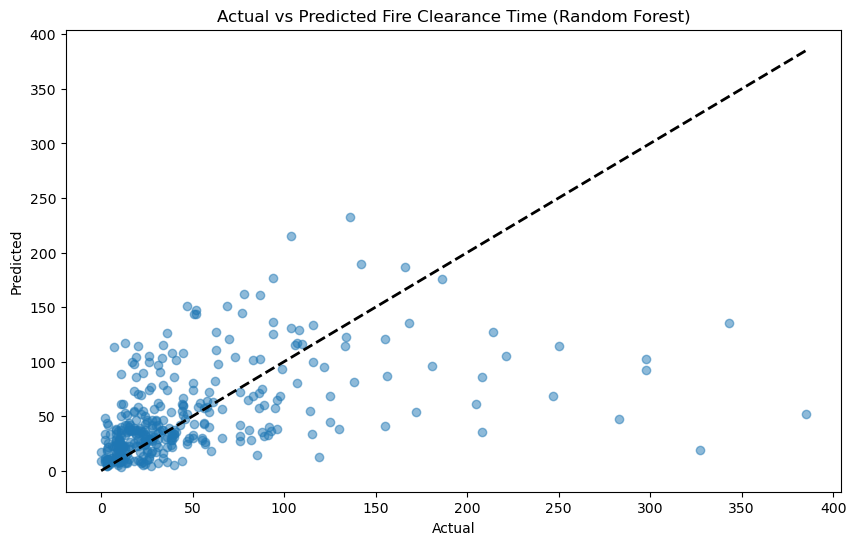

Decision Tree 均方误差（MSE）：4338.053824362606
Decision Tree R²：-0.3033902622900011


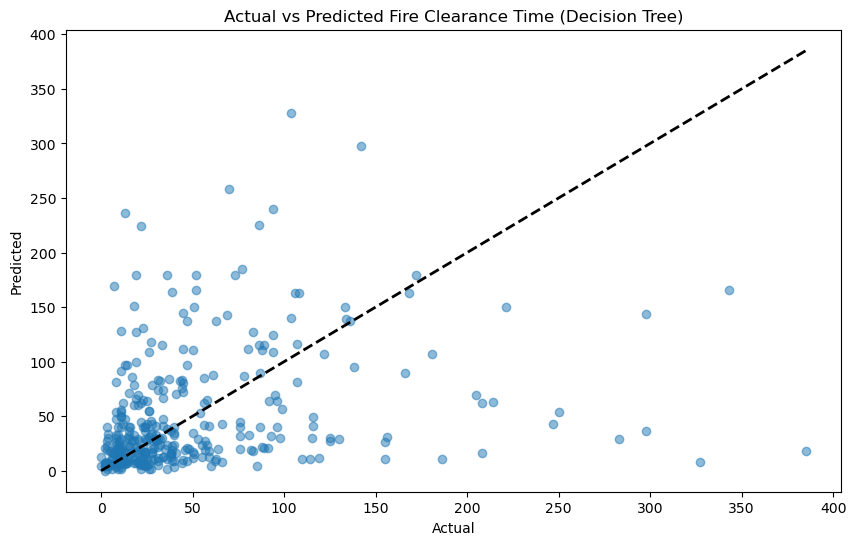

Gradient Boosting 均方误差（MSE）：2429.9463778016484
Gradient Boosting R²：0.2699102927384994


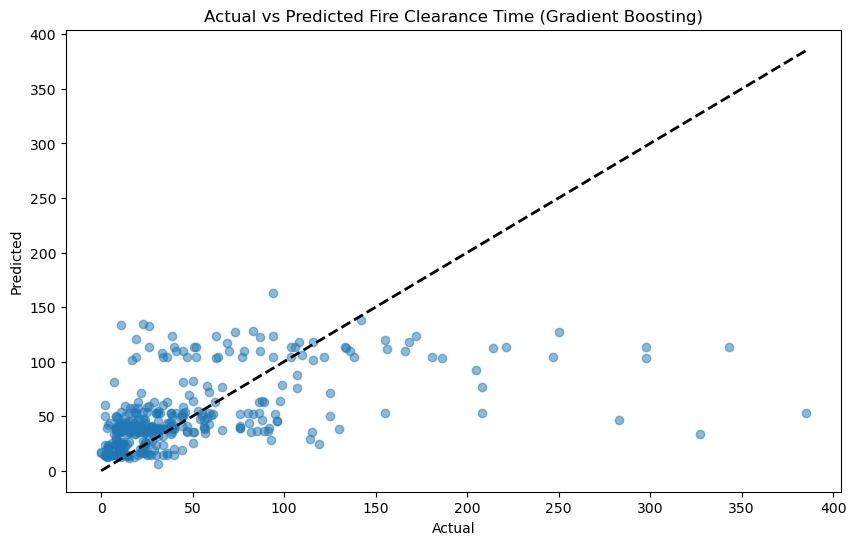

XGBoost 均方误差（MSE）：2788.125765129479
XGBoost R²：0.16229348010831324


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


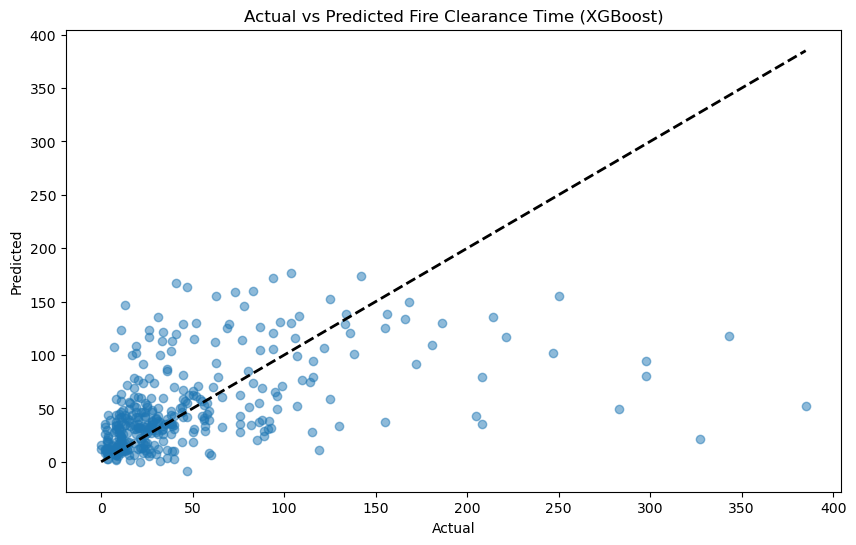

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 查看数据是否存在缺失值
print("数据中的缺失值：")
print(data.isnull().sum())

# 删除包含缺失值的行
data = data.dropna()

# 更新特征和目标变量
X = data[['RESPONSE_TIME', 'DEPT_STA', 'INC_TYPE', 'SHIFT', 'PROP_VAL']]
y = data['FIRE_CLEARANCE_TIME']

# 将分类变量转换为哑变量
X = pd.get_dummies(X, columns=['DEPT_STA', 'INC_TYPE', 'SHIFT'])

# 使用IQR方法去除异常值
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.05)  # 调整为 0.05 和 0.95 分位数
    Q3 = df[col].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# 去除RESPONSE_TIME和FIRE_CLEARANCE_TIME的异常值
X = remove_outliers(X, 'RESPONSE_TIME')
y = y[X.index]
X = remove_outliers(X, 'RESPONSE_TIME')
y = y[X.index]

# 可视化数据分布
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(X['RESPONSE_TIME'])
plt.title('Response Time Distribution')
plt.subplot(1, 2, 2)
sns.boxplot(y)
plt.title('Fire Clearance Time Distribution')
plt.show()

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义评估函数
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2, y_pred

# 模型列表
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

# 评估所有模型
results = {}
for model_name, model in models.items():
    mse, r2, y_pred = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[model_name] = (mse, r2)
    print(f"{model_name} 均方误差（MSE）：{mse}")
    print(f"{model_name} R²：{r2}")

    # 可视化预测结果与实际结果的对比
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Fire Clearance Time ({model_name})')
    plt.show()


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.699e+02, tolerance: 4.360e+02
  model = cd_fast.enet_coordinate_descent(


Best Lasso Params: {'alpha': 1}
调优后的Lasso回归均方误差（MSE）：2356.2953958743783
调优后的Lasso回归R²：0.2920391036151615


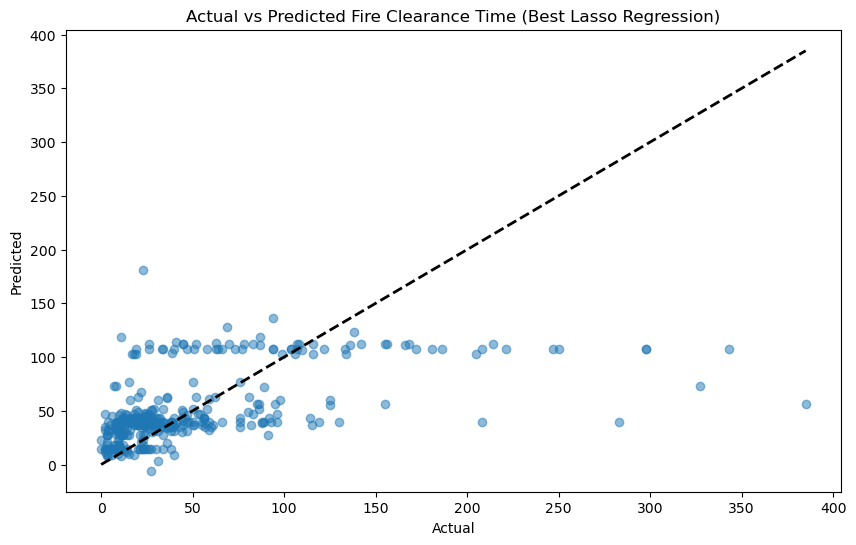

In [34]:
from sklearn.model_selection import GridSearchCV

# 超参数调优函数
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# 定义Lasso回归的超参数范围
lasso_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# 调优Lasso回归
best_lasso, best_params = hyperparameter_tuning(Lasso(), lasso_param_grid, X_train_scaled, y_train)
print(f"Best Lasso Params: {best_params}")

# 使用调优后的Lasso回归模型进行评估
mse, r2, y_pred = evaluate_model(best_lasso, X_train_scaled, X_test_scaled, y_train, y_test)
print(f"调优后的Lasso回归均方误差（MSE）：{mse}")
print(f"调优后的Lasso回归R²：{r2}")

# 可视化调优后的预测结果与实际结果的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fire Clearance Time (Best Lasso Regression)')
plt.show()


数据中的缺失值：
FDID                   0
RESPONSE_TIME          0
FIRE_CLEARANCE_TIME    1
DEPT_STA               0
INC_TYPE               0
SHIFT                  0
PROP_VAL               0
dtype: int64


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


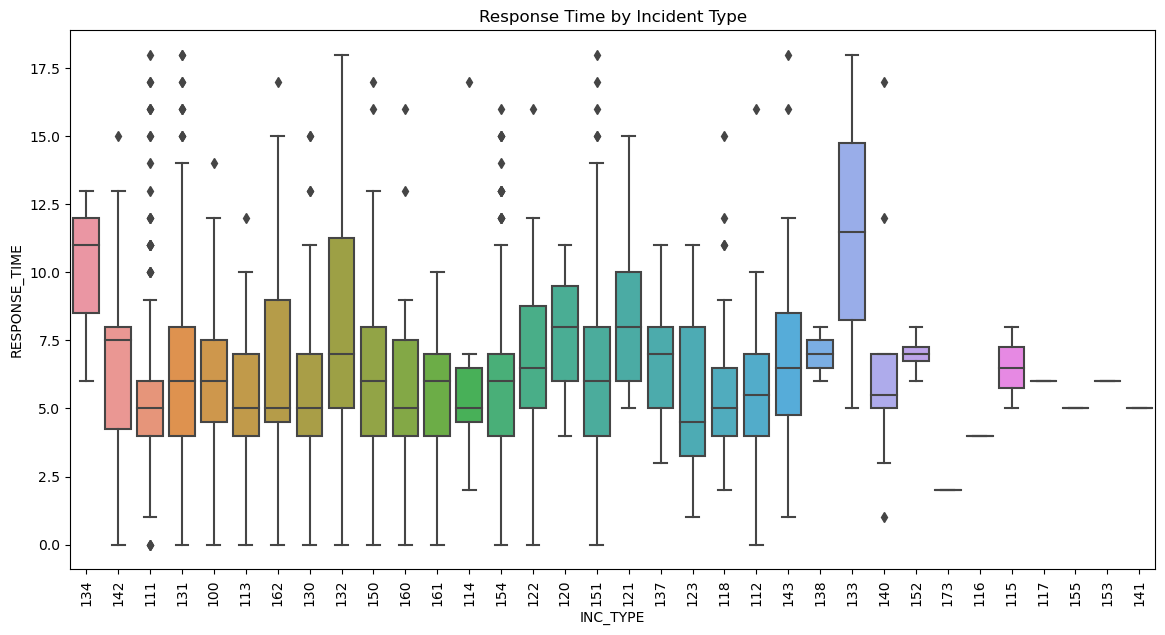

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


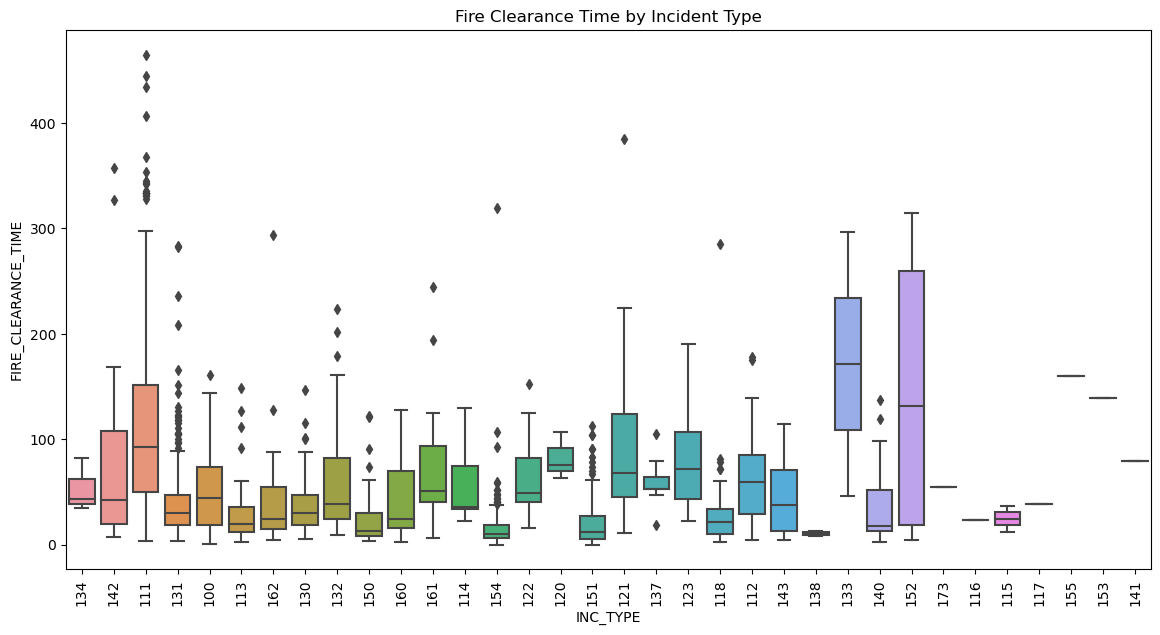

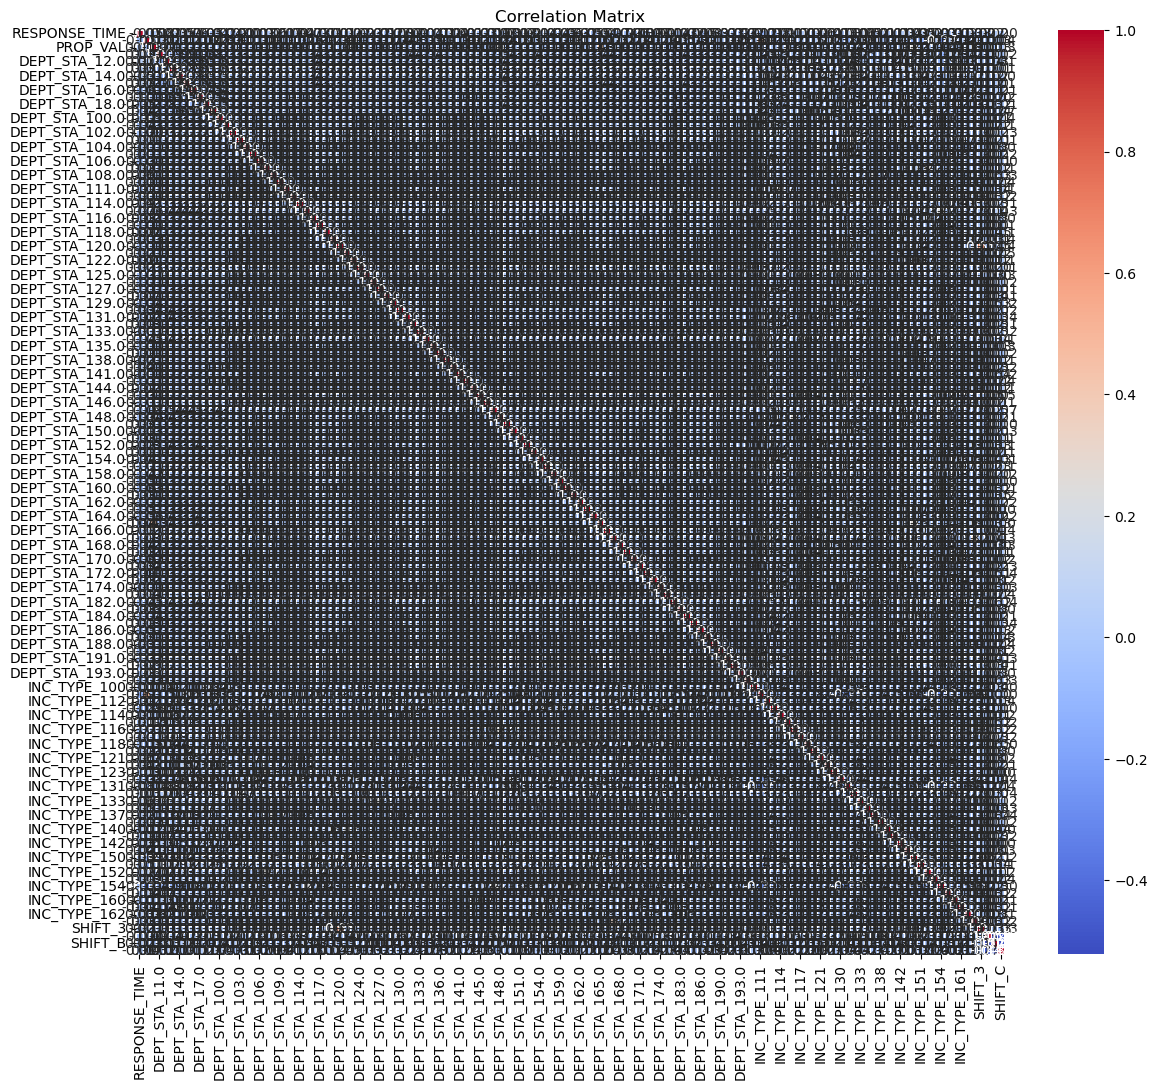

Incident Type Correlation with Fire Clearance Time:
                     FIRE_CLEARANCE_TIME
FIRE_CLEARANCE_TIME             1.000000
INC_TYPE_111                    0.498708
DEPT_STA_100.0                  0.157421
INC_TYPE_152                    0.071571
INC_TYPE_121                    0.070791
...                                  ...
INC_TYPE_113                   -0.085293
INC_TYPE_150                   -0.093909
INC_TYPE_131                   -0.100940
INC_TYPE_151                   -0.112559
INC_TYPE_154                   -0.271257

[130 rows x 1 columns]


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 查看数据是否存在缺失值
print("数据中的缺失值：")
print(data.isnull().sum())

# 删除包含缺失值的行
data = data.dropna()

# 确保 INC_TYPE 是数值型数据
data['INC_TYPE'] = data['INC_TYPE'].astype(str)

# 数据可视化：火灾事件类型与响应时间的关系
plt.figure(figsize=(14, 7))
sns.boxplot(x='INC_TYPE', y='RESPONSE_TIME', data=data)
plt.xticks(rotation=90)
plt.title('Response Time by Incident Type')
plt.show()

# 数据可视化：火灾事件类型与火灾清除时间的关系
plt.figure(figsize=(14, 7))
sns.boxplot(x='INC_TYPE', y='FIRE_CLEARANCE_TIME', data=data)
plt.xticks(rotation=90)
plt.title('Fire Clearance Time by Incident Type')
plt.show()

# 选择主要特征和目标变量
selected_columns = ['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME', 'DEPT_STA', 'INC_TYPE', 'SHIFT', 'PROP_VAL']
data_selected = data[selected_columns]

# 将分类变量转换为哑变量
data_selected = pd.get_dummies(data_selected, columns=['DEPT_STA', 'INC_TYPE', 'SHIFT'])

# 计算变量之间的相关性
correlation_matrix = data_selected.corr()

# 可视化相关性矩阵
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 提取INC_TYPE与其他变量的相关性
incident_type_correlation = correlation_matrix[['FIRE_CLEARANCE_TIME']].sort_values(by='FIRE_CLEARANCE_TIME', ascending=False)
print("Incident Type Correlation with Fire Clearance Time:")
print(incident_type_correlation)


数据中的缺失值：
FDID                   0
RESPONSE_TIME          0
FIRE_CLEARANCE_TIME    1
DEPT_STA               0
INC_TYPE               0
SHIFT                  0
PROP_VAL               0
dtype: int64


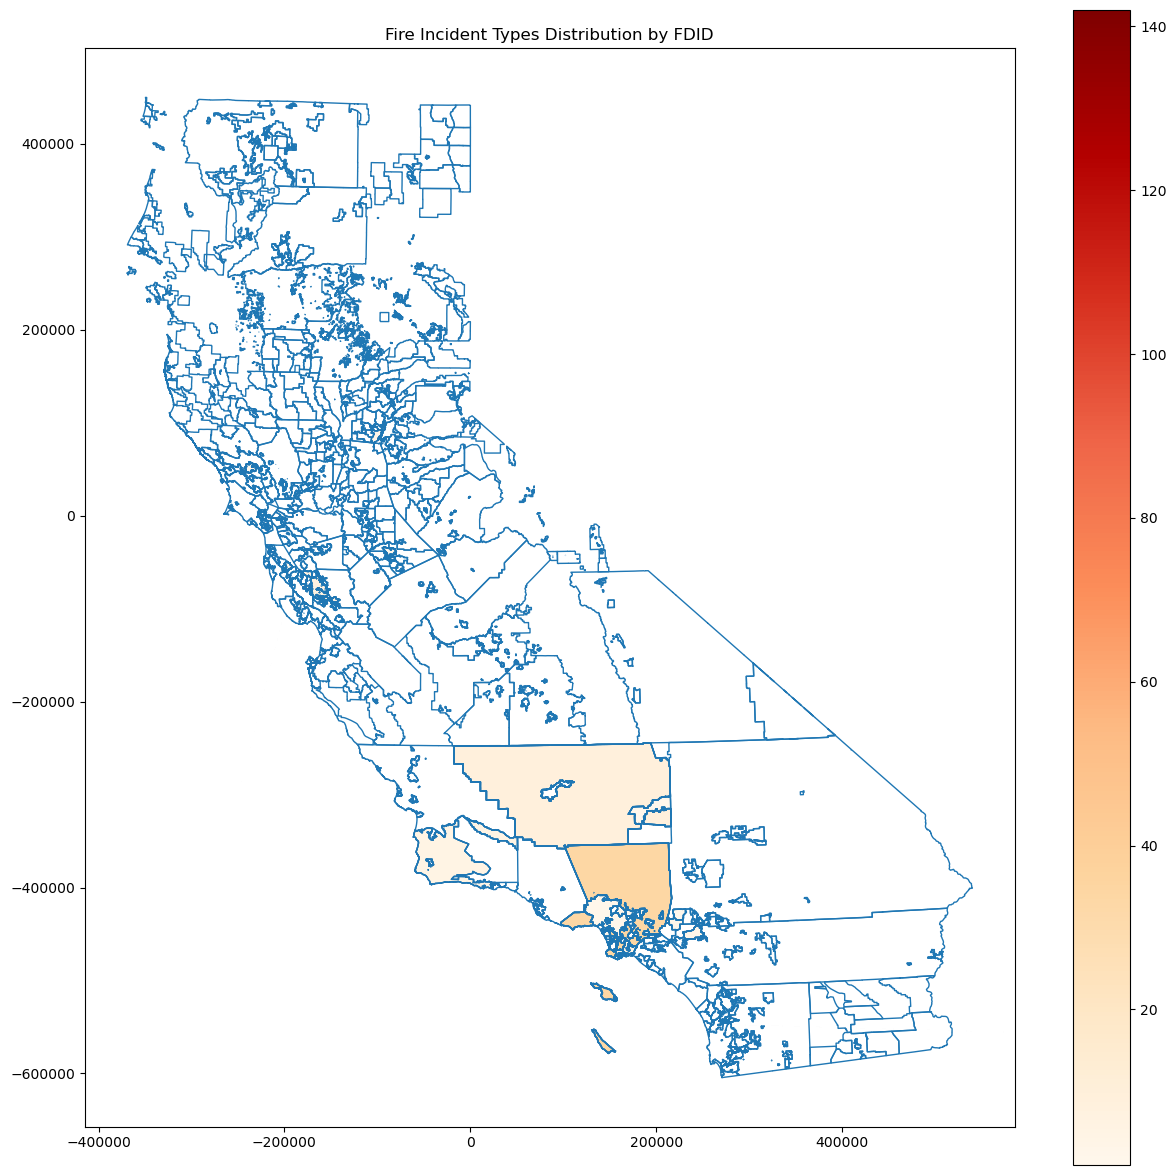

    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOITO  (510) 528-5770   

  Notes  LastUpdate                                            Website  \
0   NaN  2018-06-21                                             <Null>   
1   

In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 查看数据是否存在缺失值
print("数据中的缺失值：")
print(data.isnull().sum())

# 删除包含缺失值的行
data = data.dropna()

# 确保 INC_TYPE 和 FDID 是字符串类型
data['INC_TYPE'] = data['INC_TYPE'].astype(str)
data['FDID'] = data['FDID'].astype(str)

# 统计每个 FDID 下每种 INC_TYPE 的频率
fdid_inc_type_counts = data.groupby(['FDID', 'INC_TYPE']).size().reset_index(name='count')

# 选择前几个最常见的 INC_TYPE 进行可视化
top_inc_types = fdid_inc_type_counts['INC_TYPE'].value_counts().head(5).index
fdid_inc_type_counts_top = fdid_inc_type_counts[fdid_inc_type_counts['INC_TYPE'].isin(top_inc_types)]

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并频率数据到 GeoDataFrame
gdf = gdf.merge(fdid_inc_type_counts_top, on='FDID', how='left')

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.boundary.plot(ax=ax, linewidth=1)
gdf.plot(column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Fire Incident Types Distribution by FDID')
plt.show()

# 输出前几个最常见的 FDID 下每种火灾事件类型的频率
print(gdf.head())


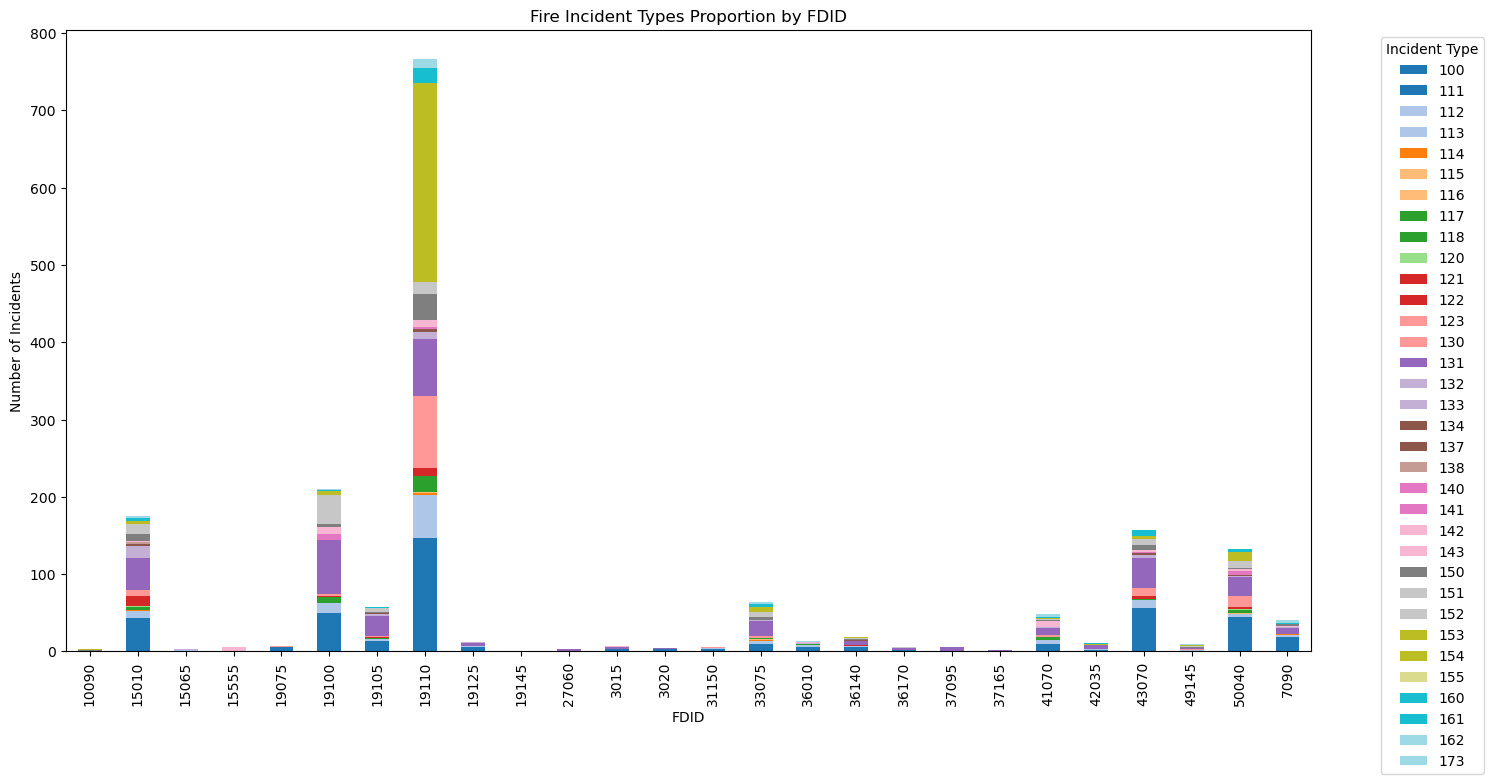

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 确保 FDID 和 INC_TYPE 是字符串类型
data['FDID'] = data['FDID'].astype(str)
data['INC_TYPE'] = data['INC_TYPE'].astype(str)

# 统计每个 FDID 下每种 INC_TYPE 的频率
fdid_inc_type_counts = data.groupby(['FDID', 'INC_TYPE']).size().unstack(fill_value=0)

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(15, 8))
fdid_inc_type_counts.plot(kind='bar', stacked=True, ax=ax, cmap='tab20')

ax.set_title('Fire Incident Types Proportion by FDID')
ax.set_xlabel('FDID')
ax.set_ylabel('Number of Incidents')
plt.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


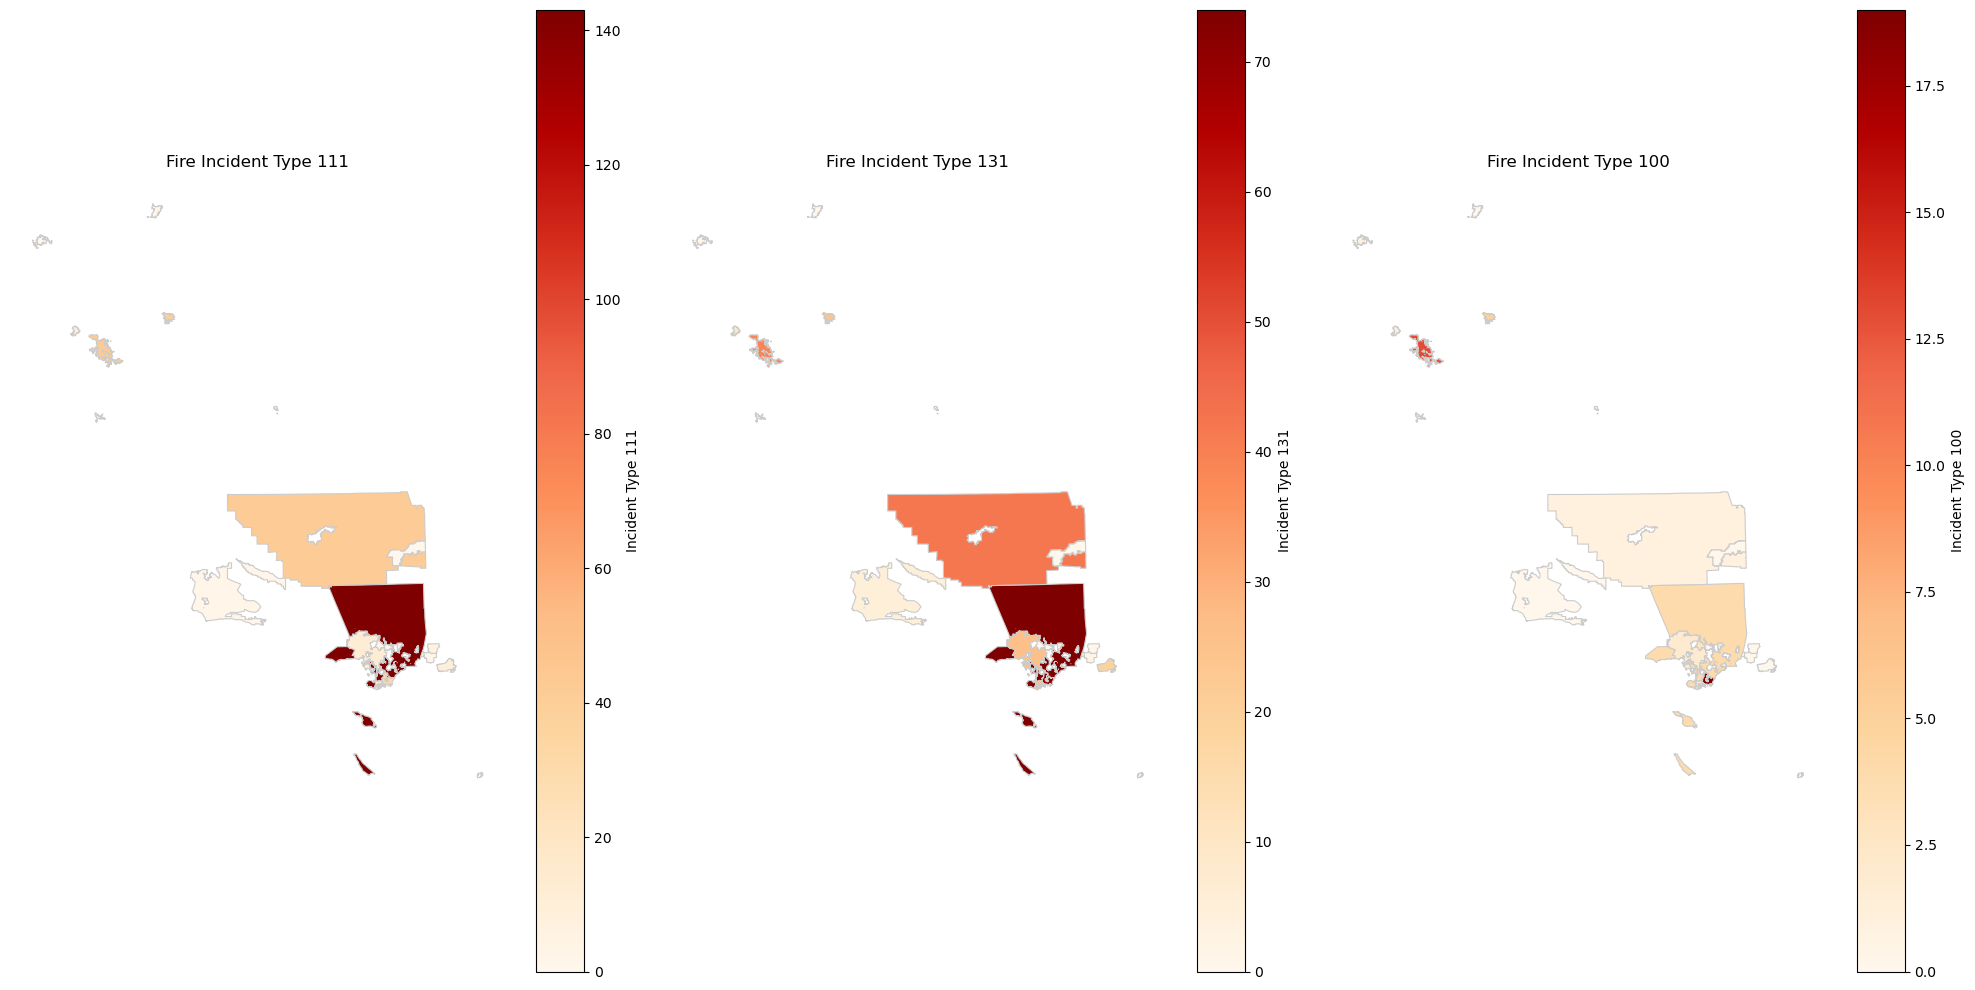

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 确保 INC_TYPE 和 FDID 是字符串类型
data['INC_TYPE'] = data['INC_TYPE'].astype(str)
data['FDID'] = data['FDID'].astype(str)

# 选择要可视化的火灾类型
selected_inc_types = ['111', '131', '100']  # 示例选择

# 统计每个 FDID 下选定 INC_TYPE 的频率
fdid_inc_type_counts = data[data['INC_TYPE'].isin(selected_inc_types)].groupby(['FDID', 'INC_TYPE']).size().unstack(fill_value=0)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并火灾类型数据到 GeoDataFrame
gdf = gdf.set_index('FDID').join(fdid_inc_type_counts)

# 绘制分面地图
fig, axes = plt.subplots(1, len(selected_inc_types), figsize=(20, 10))
for i, inc_type in enumerate(selected_inc_types):
    ax = axes[i]
    gdf.plot(column=inc_type, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': f'Incident Type {inc_type}'})
    ax.set_title(f'Fire Incident Type {inc_type}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 确保 INC_TYPE 和 FDID 是字符串类型
data['INC_TYPE'] = data['INC_TYPE'].astype(str)
data['FDID'] = data['FDID'].astype(str)

# 选择要可视化的火灾类型
selected_inc_types = ['111', '131', '100']  # 示例选择

# 统计每个 FDID 下选定 INC_TYPE 的频率
fdid_inc_type_counts = data[data['INC_TYPE'].isin(selected_inc_types)].groupby(['FDID', 'INC_TYPE']).size().unstack(fill_value=0)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并火灾类型数据到 GeoDataFrame
gdf = gdf.set_index('FDID').join(fdid_inc_type_counts)

# 设定全局的色彩范围
vmin, vmax = 0, gdf[selected_inc_types].max().max()

# 单独生成每张地图并保存
for inc_type in selected_inc_types:
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column=inc_type, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
             legend_kwds={'label': f'Incident Type {inc_type}', 'shrink': 0.6},
             vmin=vmin, vmax=vmax)
    ax.set_title(f'Fire Incident Type {inc_type}')
    ax.axis('off')

    # 保存图片
    plt.savefig(f'fire_incident_type_{inc_type}.png', dpi=300, bbox_inches='tight')
    plt.close()


In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 确保 INC_TYPE 和 FDID 是字符串类型
data['INC_TYPE'] = data['INC_TYPE'].astype(str)
data['FDID'] = data['FDID'].astype(str)

# 选择要可视化的火灾类型
selected_inc_types = ['111', '131', '100']  # 示例选择

# 统计每个 FDID 下选定 INC_TYPE 的频率
fdid_inc_type_counts = data[data['INC_TYPE'].isin(selected_inc_types)].groupby(['FDID', 'INC_TYPE']).size().unstack(fill_value=0)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并火灾类型数据到 GeoDataFrame
gdf = gdf.set_index('FDID').join(fdid_inc_type_counts)

# 设置统一的色卡范围
vmin, vmax = 0, 140

# 为每个火灾类型生成独立的地图
for inc_type in selected_inc_types:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')  # 绘制所有区域的边界线
    gdf.plot(column=inc_type, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
             legend_kwds={'label': f'Incident Type {inc_type}', 'shrink': 0.6}, vmin=vmin, vmax=vmax)
    ax.set_title(f'Fire Incident Type {inc_type}')
    ax.axis('off')
    
    # 保存图像
    plt.savefig(f'fire_incident_type_{inc_type}.png', dpi=300)
    plt.close(fig)  # 关闭当前图形，释放内存


In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm

# 文件路径
cleaned_data_file = 'morans_data/2022/cleaned_fire_2022.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取数据
data = pd.read_csv(cleaned_data_file)

# 确保 INC_TYPE 和 FDID 是字符串类型
data['INC_TYPE'] = data['INC_TYPE'].astype(str)
data['FDID'] = data['FDID'].astype(str)

# 选择要可视化的火灾类型
selected_inc_types = ['111', '131', '100']  # 示例选择

# 统计每个 FDID 下选定 INC_TYPE 的频率
fdid_inc_type_counts = data[data['INC_TYPE'].isin(selected_inc_types)].groupby(['FDID', 'INC_TYPE']).size().unstack(fill_value=0)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并火灾类型数据到 GeoDataFrame
gdf = gdf.set_index('FDID').join(fdid_inc_type_counts)

# 设置统一的色卡范围
vmin, vmax = 0, 140
levels = [0, 10, 20, 40, 60, 80, 100, 120, 140]  # 定义色彩分段
cmap = plt.cm.Reds
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# 为每个火灾类型生成独立的地图
for inc_type in selected_inc_types:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')  # 绘制所有区域的边界线
    gdf.plot(column=inc_type, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
             legend_kwds={'label': f'Incident Type {inc_type}', 'shrink': 0.6}, norm=norm)
    ax.set_title(f'Fire Incident Type {inc_type}')
    ax.axis('off')
    
    # 保存图像
    plt.savefig(f'fire_incident_type1_{inc_type}.png', dpi=300)
    plt.close(fig)  # 关闭当前图形，释放内存


In [52]:
# 将 FDID 转换为字符串类型
data['FDID'] = data['FDID'].astype(str)

# 检查 SHIFT 的唯一值以决定转换方式
print("SHIFT 的唯一值：", data['SHIFT'].unique())

# 将 SHIFT 转换为类别变量（可选，取决于内容）
# 如果 SHIFT 是字母或其他非数值编码，则可能需要先转为数字编码
# 如果是分类数据, 直接用类别型处理
data['SHIFT'] = data['SHIFT'].astype('category').cat.codes

# 查看转换后的数据类型
print(data.dtypes)


SHIFT 的唯一值： ['B' 'A' 'C' '3']
FDID                    object
RESPONSE_TIME          float64
FIRE_CLEARANCE_TIME    float64
DEPT_STA               float64
INC_TYPE                 int64
SHIFT                     int8
PROP_VAL               float64
dtype: object


TypeError: can only concatenate str (not "int") to str

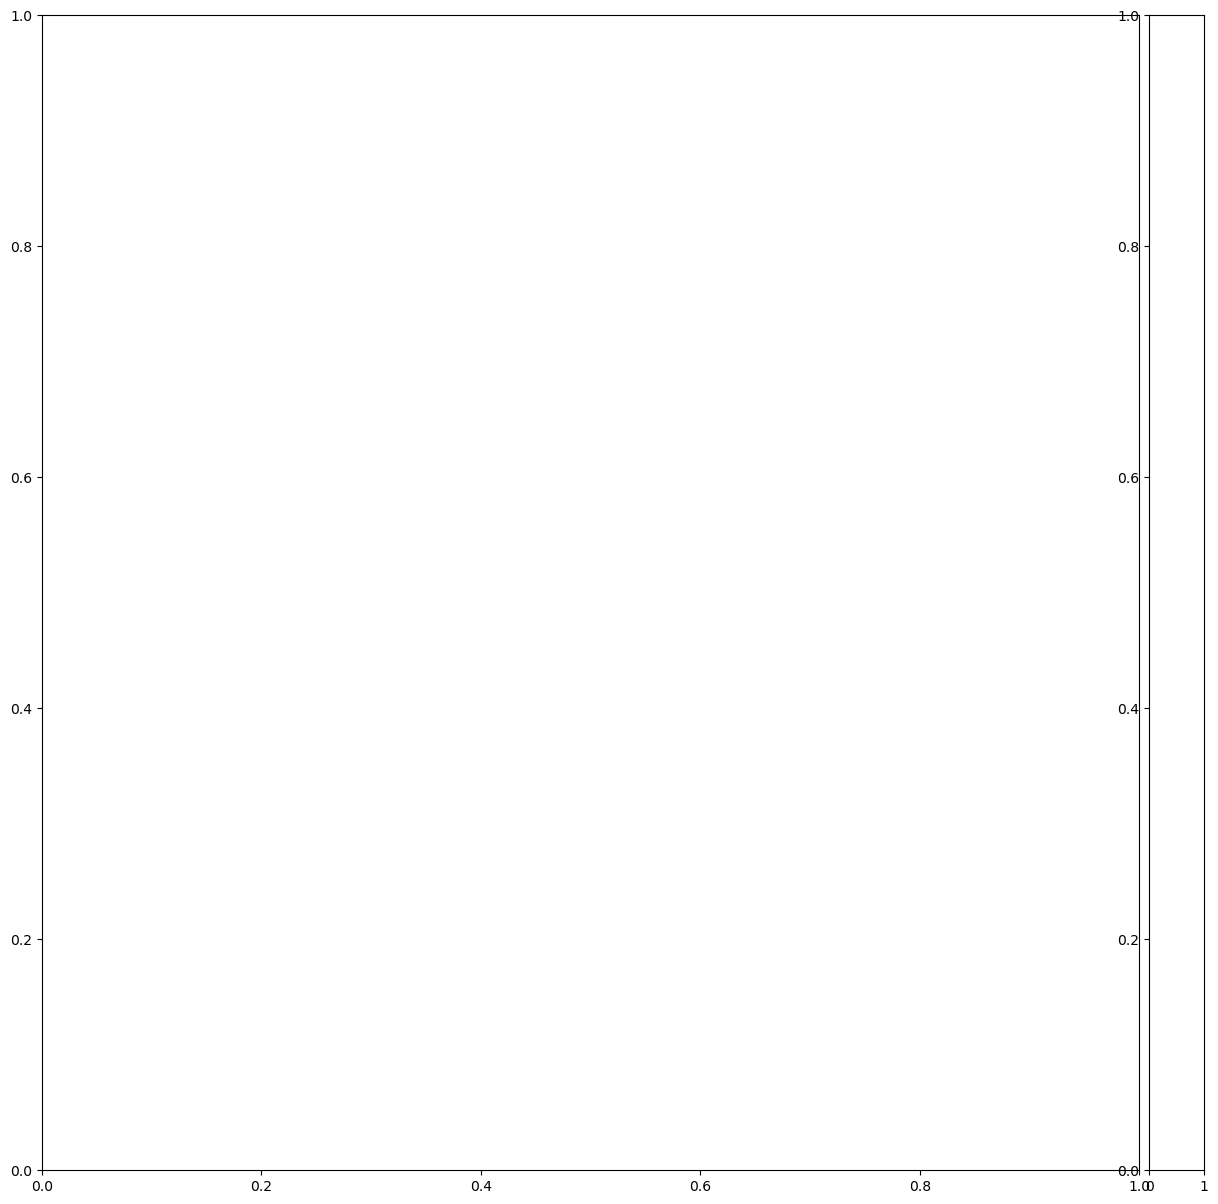

In [53]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 读取 shapefile 数据
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 将事件类型作为类别进行汇总
incident_type_summary = data.groupby(['FDID', 'INC_TYPE']).size().unstack(fill_value=0)

# 合并到地理数据中
gdf = gdf.set_index('FDID').join(incident_type_summary)

# 检查数据是否存在空值，若有则填充为0
gdf = gdf.fillna(0)

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# 遍历每个地理区域，并绘制饼图
for idx, row in gdf.iterrows():
    if row[1:].sum() > 0:
        center = row['geometry'].centroid.coords[0]
        sizes = row[1:] / row[1:].sum()
        ax.pie(sizes, center=center, radius=5000, colors=plt.cm.tab20.colors)

gdf.boundary.plot(ax=ax, linewidth=1, color='k')

ax.set_title('Fire Incident Types Distribution by FDID')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


梯度提升回归均方误差（MSE）：104838.6440387855
梯度提升回归R²：0.2036069074790956


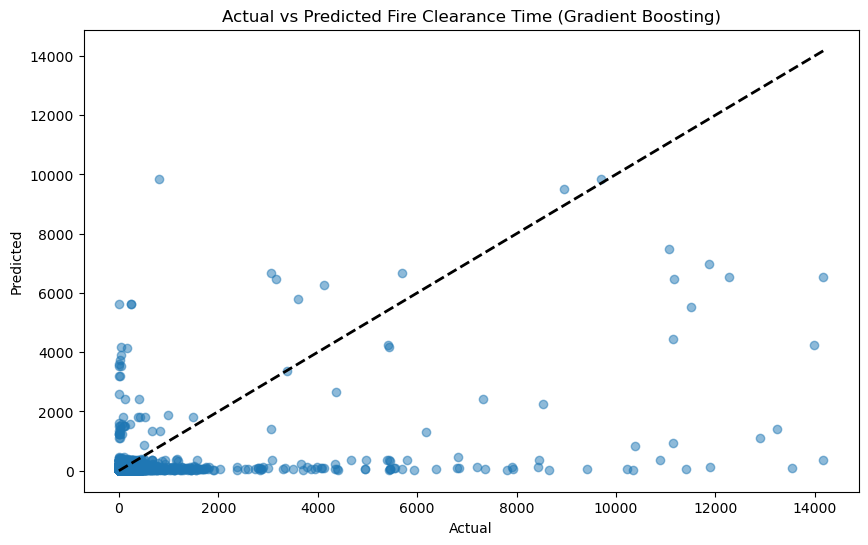

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBoost回归均方误差（MSE）：117152.67525976224
XGBoost回归R²：0.1100649745841551


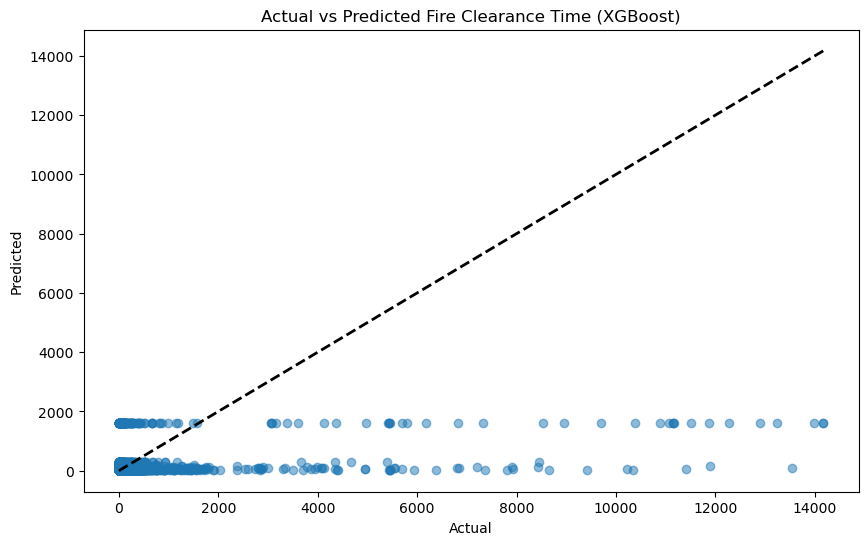